In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import numpy as np
import pandas as pd
import h5py
import fsspec
from pyproj import Proj, CRS
import matplotlib.pyplot as plt
import shapely.wkt as wkt
import rasterio
from rasterio.crs import CRS
from rasterio.transform import from_origin
from rasterio import merge
import folium
from folium import plugins
import rioxarray
import sys
sys.path.append('../../')
from src.cslc_utils import get_s3path, read_cslc, cslc_info, rasterWrite, custom_merge, colorize, getbasemaps, moving_window_mean

import warnings
warnings.filterwarnings('ignore')

In [3]:
data_dir = 's3://opera-pst-rs-pop1/products/CSLC_S1'
burst_id = ['T144-308014-IW2', 
            'T144-308015-IW2']

# get list of dates
b1paths = (open(f"{burst_id[0]}.txt","r").read().split("\n"))
b2paths = (open(f"{burst_id[1]}.txt","r").read().split("\n"))
dates = [path[40:48] for path in b1paths]
nd = len(dates)

# send to dataframe
file_df = pd.DataFrame({'Date':dates,f'{burst_id[0]}':b1paths,f'{burst_id[1]}':b2paths})

In [4]:
# Read before and after event dataset 
before = []; after = []  

for id in burst_id: 
    path_h5 = file_df[f'{id}'][0][:-1]
    dat = read_cslc(f'{data_dir}/{path_h5}/{path_h5}.h5')
    before.append(dat)

for id in burst_id:  
    path_h5 = file_df[f'{id}'][1][:-1]
    dat = read_cslc(f'{data_dir}/{path_h5}/{path_h5}.h5')
    after.append(dat)

Streaming: s3://opera-pst-rs-pop1/products/CSLC_S1/OPERA_L2_CSLC-S1A_IW_T144-308014-IW2_VV_20151127T135951Z_v0.1_20230708T230140Z/OPERA_L2_CSLC-S1A_IW_T144-308014-IW2_VV_20151127T135951Z_v0.1_20230708T230140Z.h5
Streaming: s3://opera-pst-rs-pop1/products/CSLC_S1/OPERA_L2_CSLC-S1A_IW_T144-308015-IW2_VV_20151127T135954Z_v0.1_20230708T230140Z/OPERA_L2_CSLC-S1A_IW_T144-308015-IW2_VV_20151127T135954Z_v0.1_20230708T230140Z.h5
Streaming: s3://opera-pst-rs-pop1/products/CSLC_S1/OPERA_L2_CSLC-S1A_IW_T144-308014-IW2_VV_20151221T135950Z_v0.1_20230708T230145Z/OPERA_L2_CSLC-S1A_IW_T144-308014-IW2_VV_20151221T135950Z_v0.1_20230708T230145Z.h5
Streaming: s3://opera-pst-rs-pop1/products/CSLC_S1/OPERA_L2_CSLC-S1A_IW_T144-308015-IW2_VV_20151221T135953Z_v0.1_20230708T230145Z/OPERA_L2_CSLC-S1A_IW_T144-308015-IW2_VV_20151221T135953Z_v0.1_20230708T230145Z.h5


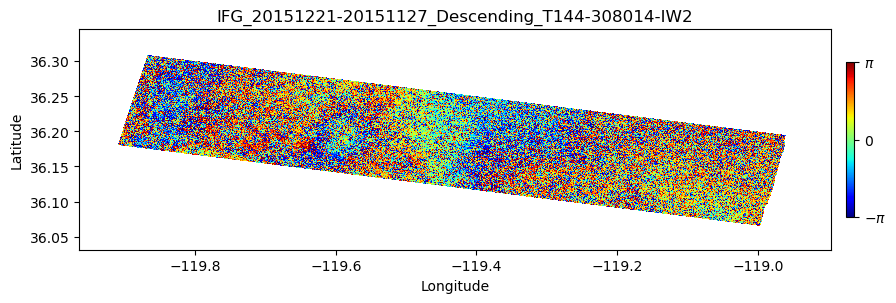

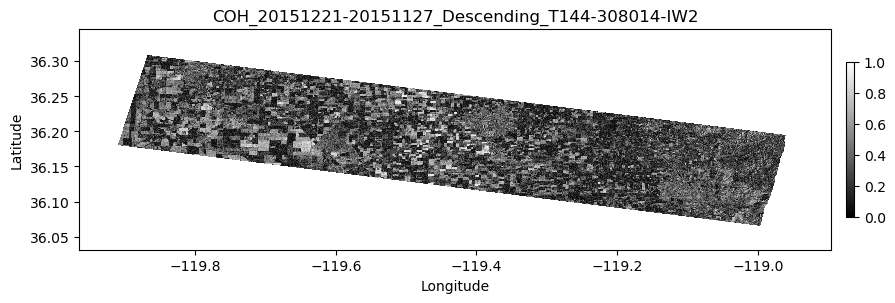

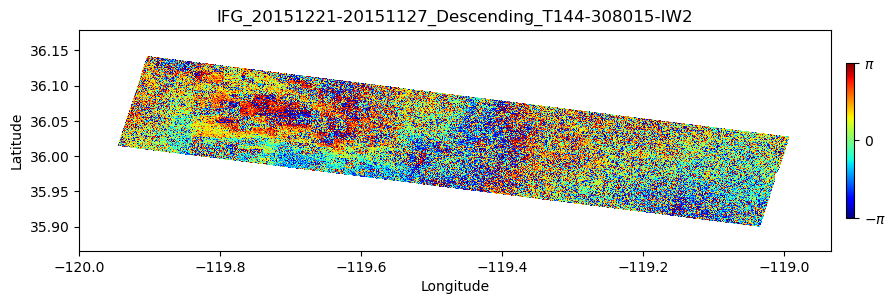

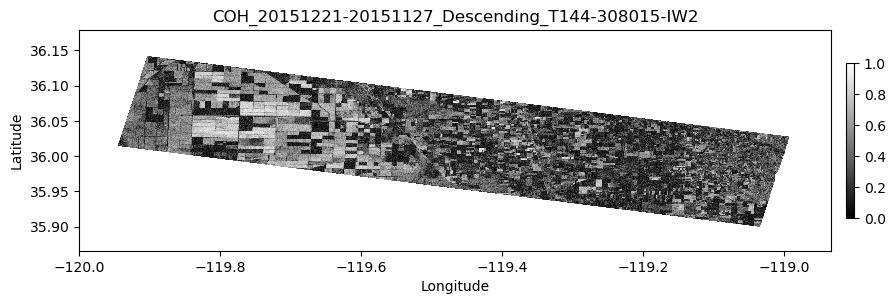

In [5]:
%matplotlib inline

for i, id in enumerate(burst_id):
    path_h5 = file_df[f'{id}'][30][:-1]
    xcoor, ycoor, dx, dy, epsg, bounding_polygon, orbit_direction = cslc_info(f'{data_dir}/{path_h5}/{path_h5}.h5')
    cslc_poly = wkt.loads(bounding_polygon)
    bbox = [cslc_poly.bounds[0], cslc_poly.bounds[2], cslc_poly.bounds[1], cslc_poly.bounds[3]]

    # Calculate burst-wise interferogram
    ifg = before[i] * np.conj(after[i])

    # Calculate the correlation/coherence
    ifg_cpx = np.exp(1j * np.nan_to_num(np.angle(ifg)))
    coh = np.clip(np.abs(moving_window_mean(ifg_cpx, 10)), 0, 1)

    # Mask nan values and zero values based on merged ifg file
    nan_mask = np.isnan(ifg)
    zero_mask = ifg == 0
    coh[nan_mask] = np.nan
    coh[zero_mask] = 0


    # Plot each interferogram
    fig, ax = plt.subplots(figsize=(10,3))
    cax = ax.imshow(colorize(np.angle(ifg), 'jet', -np.pi, np.pi), cmap='jet',interpolation='nearest', origin='upper',extent=bbox, vmin=-np.pi, vmax=np.pi)
    cbar = fig.colorbar(cax,orientation='vertical',fraction=0.01,pad=0.02)
    cbar.set_ticks([-np.pi, 0., np.pi])
    cbar.set_ticklabels([r'$-\pi$', '$0$', r'$\pi$'])
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'IFG_{dates[1]}-{dates[0]}_{orbit_direction}_{id}',fontsize=12)

    fig, ax = plt.subplots(figsize=(10,3))
    cax = ax.imshow(colorize(coh, 'gray', 0, 1), cmap='gray',interpolation='nearest', origin='upper',extent=bbox, vmin=0., vmax=1.)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'COH_{dates[1]}-{dates[0]}_{orbit_direction}_{id}',fontsize=12)
    fig.colorbar(cax,orientation='vertical',fraction=0.01,pad=0.02)
    plt.show()


    # Save each interferogram's phase and coherence as GeoTiff
    transform = from_origin(xcoor[0],ycoor[0],dx,np.abs(dy))
    rasterWrite(f'complex_ifg_{id}.tif',np.angle(ifg),transform,epsg,dtype='float32')
    rasterWrite(f'ifg_amp_{id}.tif',np.abs(ifg),transform,epsg,dtype='float32')
    rasterWrite(f'coherence_{id}.tif',coh,transform,epsg,dtype='float32')

In [21]:
# Merge GeoTiff files with rasterio
ifg_files = [(f'complex_ifg_{id}.tif') for id in burst_id]
ifg_files_to_mosaic = []

for f in ifg_files:
    src = rasterio.open(f)
    ifg_files_to_mosaic.append(src)

amp_files = [(f'ifg_amp_{id}.tif') for id in burst_id]
amp_arrays = [rasterio.open(file).read(1) for file in amp_files]
amp_arrays = [np.array(amp) for amp in amp_arrays]

coh_files = [(f'coherence_{id}.tif') for id in burst_id]
coh_arrays = [rasterio.open(file).read(1) for file in coh_files]
coh_arrays = [np.array(coh) for coh in coh_arrays]

In [29]:
# replace old with new
dest, output_transform=merge.merge(ifg_files_to_mosaic,nodata=np.nan,method=custom_merge)
with rasterio.open(ifg_files[0]) as src:
        out_meta = src.meta.copy() 
out_meta.update({"driver": "GTiff",
                 "height": dest.shape[1],
                 "width": dest.shape[2],
                 "transform": output_transform,
                 "dtype": "float32",
                 "nodata": np.nan})
with rasterio.open('merged_old_new.tif', "w", **out_meta) as dest1:
        dest1.write(dest)
        dest1.close()

In [ ]:
def custom_merge(old_data, new_data, old_nodata, new_nodata, **kwargs):    
    mask = np.logical_and(~old_nodata, ~new_nodata)
    old_data[mask] = new_data[mask]
    mask = np.logical_and(old_nodata, ~new_nodata)
    old_data[mask] = new_data[mask]

In [ ]:
# chatGPT
def read_weight_array(weight_tif):
    with rasterio.open(weight_tif) as weight_ds:
        weight_array = weight_ds.read(1)
    return weight_array

def weighted_average_merge(input_files, weight_files):
    # Read input raster files and their metadata
    datasets = [rasterio.open(file) for file in input_files]
    data, out_trans = merge(datasets)

    # Read weight arrays from weight GeoTIFFs
    weight_arrays = [read_weight_array(weight_tif) for weight_tif in weight_files]

    # Ensure weight arrays have the same shape as the data
    for weight_arr in weight_arrays:
        assert weight_arr.shape == data[0].shape, "Weight arrays must have the same shape as the input rasters."

    # Convert weight arrays to numpy arrays
    weight_arrays = [np.array(weight) for weight in weight_arrays]

    # Normalize the weights to ensure they sum up to 1 for each pixel
    total_weights = np.sum(weight_arrays, axis=0)
    weights_normalized = weight_arrays / total_weights

    # Perform the weighted average
    weighted_data = np.zeros(data.shape, dtype=np.float32)
    for i, d in enumerate(data):
        weighted_data += d * weights_normalized[i]

    # Create output raster with the weighted average result
    output_profile = datasets[0].profile
    output_profile.update(count=1, dtype='float32', transform=out_trans)
    with rasterio.open('output_weighted_average.tif', 'w', **output_profile) as dst:
        dst.write(weighted_data[None, :, :])

    # Close all datasets
    for dataset in datasets:
        dataset.close()

# Example usage
input_files = ['file1.tif', 'file2.tif', 'file3.tif']
# Example weight GeoTIFF files (must have the same shape as the input rasters)
weight_files = ['weight1.tif', 'weight2.tif', 'weight3.tif']

# Merge with weighted average using the provided weight GeoTIFFs
weighted_average_merge(input_files, weight_files)



In [30]:
# Read the merged raster file
src = rioxarray.open_rasterio('merged_old_new.tif')
merged_ifg = src.rio.reproject("EPSG:4326")[0]             # Folium maps are in EPSG:4326
minlon,minlat,maxlon,maxlat = merged_ifg.rio.bounds()

# Downsample for folium visualization and attach RGBA color to numpy array
colored_merged_ifg = colorize(merged_ifg[::6][::6], 'jet', -np.pi, np.pi)

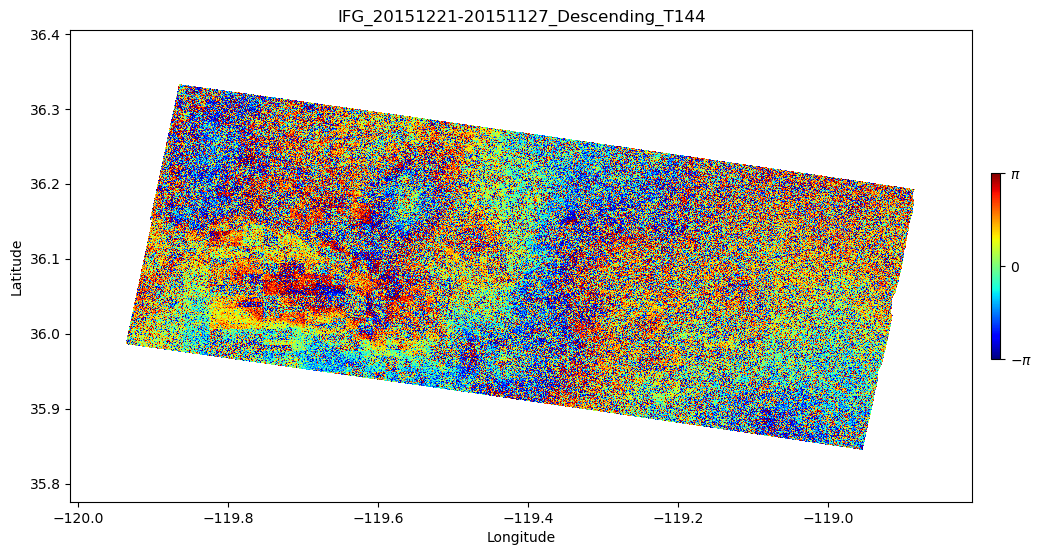

In [32]:
# Define new bounding box
new_bbox = [minlon,maxlon,minlat,maxlat]

# Plot using Matplotlib
fig, ax = plt.subplots(figsize=[12,9])
cax = ax.imshow(merged_ifg, cmap='jet',interpolation='nearest', origin='upper',extent=new_bbox)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'IFG_{dates[1]}-{dates[0]}_{orbit_direction}_{burst_id[0][:4]}',fontsize=12)
cbar = fig.colorbar(cax,orientation='vertical',fraction=0.01,pad=0.02)
cbar.set_ticks([-np.pi, 0., np.pi])
cbar.set_ticklabels([r'$-\pi$', '$0$', r'$\pi$'])
plt.show()


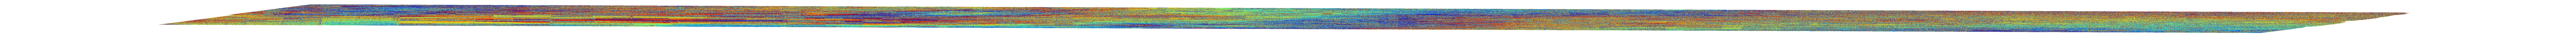

In [33]:
# Overlay merged bursts onto a basemap.
# Initialize Folium basemap and define center of mapview
xmid =(new_bbox[0]+new_bbox[1])/2 ; ymid = (new_bbox[2]+new_bbox[3])/2
m = folium.Map(location=[ymid, xmid], zoom_start=9, tiles='Stamen Terrain', show=True)

# Add custom basemaps
basemaps = getbasemaps()
for basemap in basemaps:
    basemaps[basemap].add_to(m)

# Overlay merged interferogram on a basemap
folium.raster_layers.ImageOverlay(colored_merged_ifg, 
                                        opacity=1.0, 
                                        bounds=[[new_bbox[2],new_bbox[0]],[new_bbox[3],new_bbox[1]]],
                                        interactive=False,
                                        name='Phase',
                                        show=True).add_to(m)


#layer Control
m.add_child(folium.LayerControl())

# Add fullscreen button
plugins.Fullscreen().add_to(m)

#Add inset minimap image
minimap = plugins.MiniMap(width=300, height=300)
m.add_child(minimap)

#Mouse Position
fmtr = "function(num) {return L.Util.formatNum(num, 3) + ' º ';};"
plugins.MousePosition(position='bottomright', separator=' | ', prefix="Lat/Lon:",
                     lat_formatter=fmtr, lng_formatter=fmtr).add_to(m)

#Display
m